# Assignment 3 : Sequence labelling with RNNs
In this assignement we will ask you to perform POS tagging.

You are asked to follow these steps:
*   Download the corpora and split it in training and test sets, structuring a dataframe.
*   Embed the words using GloVe embeddings
*   Create a baseline model, using a simple neural architecture
*   Experiment doing small modifications to the model
*   Evaluate your best model
*   Analyze the errors of your model

**Corpora**:
Ignore the numeric value in the third column, use only the words/symbols and its label.
https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip 

**Splits**: documents 1-100 are the train set, 101-150 validation set, 151-199 test set.

**Baseline**: two layers architecture: a Bidirectional LSTM and a Dense/Fully-Connected layer on top.
**Modifications**: experiment using a GRU instead of the LSTM, adding an additional LSTM layer, and using a CRF in addition to the LSTM. Each of this change must be done by itself (don't mix these modifications).<br>
1) BiLSTM +  FC <br>
2) BiGRU + FC <br>
3) BiLSTMx2 + FC <br>
4) BiLSTM +  FC + CRF <br>
**Training and Experiments**: all the experiments must involve only the training and validation sets.

**Evaluation**: in the end, only the best model of your choice must be evaluated on the test set. The main metric must be F1-Macro computed between the various part of speech (without considering punctuation classes).

**Error Analysis** (optional) : analyze the errors done by your model, try to understand which may be the causes and think about how to improve it.

**Report**: You are asked to deliver a small report of about 4-5 lines in the .txt file that sums up your findings.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext

from torchtext import data
from torchtext import datasets

import spacy
import numpy as np

import time
import random
import os
import matplotlib.pyplot as plt

### Read Data

In [2]:
def read_data(base_dir, datafields):
    train = []
    val = []
    test = []
    for filename in sorted(os.listdir(base_dir)):
        if str(filename) < 'wsj_0100.dp': # get train data
            with open(base_dir + filename, encoding='utf-8') as f:
                words = []
                labels = []
                for line in f:
                    line = line.strip()
                    if line: # if is not empty string
                        columns = line.split()
                        words.append(columns[0]) # take the word
                        labels.append(columns[-2]) # take the POS tag
                train.append(torchtext.data.Example.fromlist([words, labels], datafields))
        elif str(filename) < 'wsj_0150.dp': # get val data
            with open(base_dir + filename, encoding='utf-8') as f:
                words = []
                labels = []
                for line in f:
                    line = line.strip()
                    if line: # if is not empty string
                        columns = line.split()
                        words.append(columns[0]) # take the word
                        labels.append(columns[-2]) # take the POS tag
                val.append(torchtext.data.Example.fromlist([words, labels], datafields))
        else: # get test data
            with open(base_dir + filename, encoding='utf-8') as f:
                words = []
                labels = []
                for line in f:
                    line = line.strip()
                    if line: # if is not empty string
                        columns = line.split()
                        words.append(columns[0]) # take the word
                        labels.append(columns[-2]) # take the POS tag
                test.append(torchtext.data.Example.fromlist([words, labels], datafields))
    return torchtext.data.Dataset(train, datafields), torchtext.data.Dataset(val, datafields), torchtext.data.Dataset(test, datafields)

### Train and evaluate utility functions

In [3]:
def categorical_accuracy(preds, y, tag_pad_idx):
    max_preds = preds.argmax(dim = 1, keepdim = True) # get the index of the max probability
    non_pad_elements = (y != tag_pad_idx).nonzero()
    correct = max_preds[non_pad_elements].squeeze(1).eq(y[non_pad_elements])
    return correct.sum() / torch.FloatTensor([y[non_pad_elements].shape[0]])

def train(model, iterator, optimizer, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        text = batch.text
        tags = batch.label
        
        optimizer.zero_grad()
        predictions = model(text)
        predictions = predictions.view(-1, predictions.shape[-1])
        tags = tags.view(-1)
        
        loss = criterion(predictions, tags)
                
        acc = categorical_accuracy(predictions, tags, tag_pad_idx)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.label
            
            predictions = model(text)
            
            predictions = predictions.view(-1, predictions.shape[-1])
            tags = tags.view(-1)
            
            loss = criterion(predictions, tags)
            
            acc = categorical_accuracy(predictions, tags, tag_pad_idx)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [4]:
text = data.Field(lower = True)
label = data.Field(unk_token = None)
fields = [('text', text), ('label', label)]
base_dir = 'dependency_treebank/'
train_data, val_data, test_data = read_data(base_dir, fields)

In [5]:
MIN_FREQ = 2

text.build_vocab(train_data, 
                 min_freq = MIN_FREQ,
                 vectors = "glove.6B.100d",
                 unk_init = torch.Tensor.normal_)

label.build_vocab(train_data)

### Create train, val and test iterator

In [6]:
BATCH_SIZE = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, val_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key = lambda x: len(x.text),
    sort_within_batch=False,
    repeat=False,
    shuffle=True)

## BiLSTM + FC model

In [7]:
class BiLSTM(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = 1, 
                            bidirectional = True)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        predictions = self.fc(self.dropout(outputs))
        return predictions

INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(label.vocab)
DROPOUT = 0.25
PAD_IDX = text.vocab.stoi[text.pad_token]
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]

model_BiLSTM = BiLSTM(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        DROPOUT, 
                        PAD_IDX)

# Initialization
pretrained_embeddings = text.vocab.vectors
model_BiLSTM.embedding.weight.data.copy_(pretrained_embeddings)
model_BiLSTM.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model_BiLSTM.parameters())
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model_BiLSTM = model_BiLSTM.to(device)
criterion = criterion.to(device)

### Train

In [8]:
N_EPOCHS = 25

best_valid_loss = float('inf')
train_loss_accum1, val_loss_accum1 = [], []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, _ = train(model_BiLSTM, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, _ = evaluate(model_BiLSTM, valid_iterator, criterion, TAG_PAD_IDX)
    
    train_loss_accum1.append(train_loss)
    val_loss_accum1.append(valid_loss)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_BiLSTM.state_dict(), 'BiLSTM.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 0m 31s
	Train Loss: 3.171
	 Val. Loss: 2.762
Epoch: 02 | Epoch Time: 0m 25s
	Train Loss: 2.525
	 Val. Loss: 2.146
Epoch: 03 | Epoch Time: 0m 24s
	Train Loss: 1.898
	 Val. Loss: 1.575
Epoch: 04 | Epoch Time: 0m 23s
	Train Loss: 1.441
	 Val. Loss: 1.266
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 1.204
	 Val. Loss: 1.072
Epoch: 06 | Epoch Time: 0m 21s
	Train Loss: 1.044
	 Val. Loss: 0.945
Epoch: 07 | Epoch Time: 0m 25s
	Train Loss: 0.958
	 Val. Loss: 0.861
Epoch: 08 | Epoch Time: 0m 25s
	Train Loss: 0.882
	 Val. Loss: 0.802
Epoch: 09 | Epoch Time: 0m 23s
	Train Loss: 0.803
	 Val. Loss: 0.759
Epoch: 10 | Epoch Time: 0m 25s
	Train Loss: 0.769
	 Val. Loss: 0.722
Epoch: 11 | Epoch Time: 0m 24s
	Train Loss: 0.740
	 Val. Loss: 0.705
Epoch: 12 | Epoch Time: 0m 23s
	Train Loss: 0.713
	 Val. Loss: 0.671
Epoch: 13 | Epoch Time: 0m 24s
	Train Loss: 0.683
	 Val. Loss: 0.649
Epoch: 14 | Epoch Time: 0m 22s
	Train Loss: 0.667
	 Val. Loss: 0.627
Epoch: 15 | Epoch Time: 0m 24s
	Tr

### Plot loss for train and val

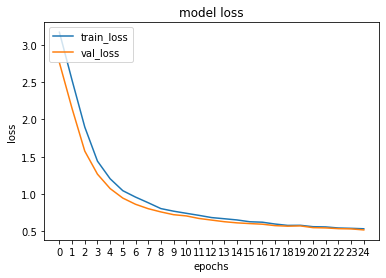

In [9]:
plt.plot(train_loss_accum1)
plt.plot(val_loss_accum1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

## BiGRU + FC model

In [10]:
class BiGRU(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 dropout,
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.requires_grad = False
        self.gru = nn.GRU(input_size=embedding_dim, hidden_size=hidden_dim, 
                          bidirectional=True, num_layers=1)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.gru(embedded)
        predictions = self.fc(self.dropout(outputs))
        return predictions

INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(label.vocab)
DROPOUT = 0.25
PAD_IDX = text.vocab.stoi[text.pad_token]
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]

model_BiGRU = BiGRU(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        DROPOUT, 
                        PAD_IDX)

# Initialization
pretrained_embeddings = text.vocab.vectors
model_BiGRU.embedding.weight.data.copy_(pretrained_embeddings)
model_BiGRU.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model_BiGRU.parameters())
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model_BiGRU = model_BiGRU.to(device)
criterion = criterion.to(device)

### Train

In [11]:
N_EPOCHS = 25

best_valid_loss = float('inf')
train_loss_accum2, val_loss_accum2 = [], []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, _ = train(model_BiGRU, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, _ = evaluate(model_BiGRU, valid_iterator, criterion, TAG_PAD_IDX)
    
    train_loss_accum2.append(train_loss)
    val_loss_accum2.append(valid_loss) 
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_BiGRU.state_dict(), 'BiGRU.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 3.063
	 Val. Loss: 2.577
Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 2.273
	 Val. Loss: 1.791
Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 1.552
	 Val. Loss: 1.266
Epoch: 04 | Epoch Time: 0m 22s
	Train Loss: 1.169
	 Val. Loss: 1.023
Epoch: 05 | Epoch Time: 0m 23s
	Train Loss: 0.965
	 Val. Loss: 0.872
Epoch: 06 | Epoch Time: 0m 23s
	Train Loss: 0.866
	 Val. Loss: 0.785
Epoch: 07 | Epoch Time: 0m 23s
	Train Loss: 0.798
	 Val. Loss: 0.727
Epoch: 08 | Epoch Time: 0m 21s
	Train Loss: 0.721
	 Val. Loss: 0.686
Epoch: 09 | Epoch Time: 0m 27s
	Train Loss: 0.698
	 Val. Loss: 0.658
Epoch: 10 | Epoch Time: 0m 28s
	Train Loss: 0.670
	 Val. Loss: 0.623
Epoch: 11 | Epoch Time: 0m 23s
	Train Loss: 0.645
	 Val. Loss: 0.601
Epoch: 12 | Epoch Time: 0m 26s
	Train Loss: 0.620
	 Val. Loss: 0.586
Epoch: 13 | Epoch Time: 0m 28s
	Train Loss: 0.605
	 Val. Loss: 0.583
Epoch: 14 | Epoch Time: 0m 25s
	Train Loss: 0.593
	 Val. Loss: 0.563
Epoch: 15 | Epoch Time: 0m 27s
	Tr

### Plot loss for train and val

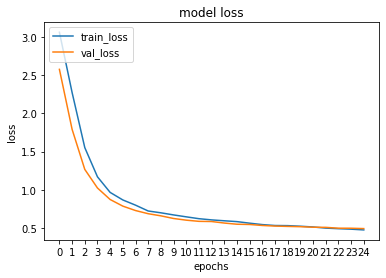

In [12]:
plt.plot(train_loss_accum2)
plt.plot(val_loss_accum2)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

## BiLSTMx2 + FC model

In [13]:
class BiLSTMx2(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = n_layers, 
                            bidirectional = True,
                            dropout = dropout if n_layers > 1 else 0)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        predictions = self.fc(self.dropout(outputs))
        return predictions
    
INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(label.vocab)
N_LAYERS = 2 # here we will jave two LSTM layers
DROPOUT = 0.25
PAD_IDX = text.vocab.stoi[text.pad_token]
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
model_BiLSTMx2 = BiLSTMx2(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        N_LAYERS, 
                        DROPOUT, 
                        PAD_IDX)

# Initialization
pretrained_embeddings = text.vocab.vectors
model_BiLSTMx2.embedding.weight.data.copy_(pretrained_embeddings)
model_BiLSTMx2.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model_BiLSTMx2.parameters())
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index = TAG_PAD_IDX)
model_BiLSTMx2 = model_BiLSTMx2.to(device)
criterion = criterion.to(device)

### Train

In [14]:
N_EPOCHS = 25

best_valid_loss = float('inf')
train_loss_accum3, val_loss_accum3 = [], []
for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, _  = train(model_BiLSTMx2, train_iterator, optimizer, criterion, TAG_PAD_IDX)
    valid_loss, _ = evaluate(model_BiLSTMx2, valid_iterator, criterion, TAG_PAD_IDX)
    train_loss_accum3.append(train_loss)
    val_loss_accum3.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_BiLSTMx2.state_dict(), 'BiLSTMx2.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 1m 50s
	Train Loss: 3.190
	 Val. Loss: 2.929
Epoch: 02 | Epoch Time: 1m 57s
	Train Loss: 2.781
	 Val. Loss: 2.430
Epoch: 03 | Epoch Time: 1m 58s
	Train Loss: 2.145
	 Val. Loss: 1.753
Epoch: 04 | Epoch Time: 1m 55s
	Train Loss: 1.611
	 Val. Loss: 1.362
Epoch: 05 | Epoch Time: 1m 53s
	Train Loss: 1.313
	 Val. Loss: 1.116
Epoch: 06 | Epoch Time: 1m 40s
	Train Loss: 1.115
	 Val. Loss: 0.963
Epoch: 07 | Epoch Time: 1m 44s
	Train Loss: 0.998
	 Val. Loss: 0.867
Epoch: 08 | Epoch Time: 1m 36s
	Train Loss: 0.893
	 Val. Loss: 0.789
Epoch: 09 | Epoch Time: 1m 37s
	Train Loss: 0.838
	 Val. Loss: 0.738
Epoch: 10 | Epoch Time: 1m 39s
	Train Loss: 0.784
	 Val. Loss: 0.694
Epoch: 11 | Epoch Time: 1m 31s
	Train Loss: 0.757
	 Val. Loss: 0.658
Epoch: 12 | Epoch Time: 1m 38s
	Train Loss: 0.707
	 Val. Loss: 0.624
Epoch: 13 | Epoch Time: 1m 46s
	Train Loss: 0.679
	 Val. Loss: 0.612
Epoch: 14 | Epoch Time: 1m 32s
	Train Loss: 0.648
	 Val. Loss: 0.589
Epoch: 15 | Epoch Time: 1m 32s
	Tr

### Plot loss for train and val

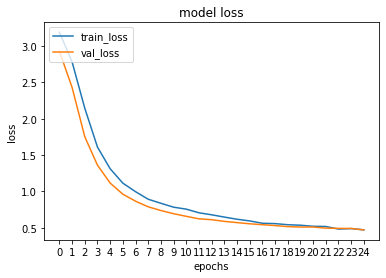

In [15]:
plt.plot(train_loss_accum3)
plt.plot(val_loss_accum3)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

##  BiLSTM + FC + CRF model

In [16]:
def train_crf(model, iterator, optimizer, mean_n_tokens, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        text = batch.text
        tags = batch.label
        
        loss = model(text, tags) / mean_n_tokens
        
        predictions = model.predict(text)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate_crf(model, iterator, optimizer, mean_n_tokens, tag_pad_idx):
    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            text = batch.text
            tags = batch.label
            
            loss = model(text, tags) / mean_n_tokens
            predictions = model.predict(text) 
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [17]:
from torchcrf import CRF
class BiLSTM_CRF(nn.Module):
    def __init__(self, 
                 input_dim, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 dropout, 
                 pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers = 1, 
                            bidirectional = True)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.crf = CRF(output_dim) # output_dim is len of labels
    def forward(self, text, labels):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        scores = self.fc(self.dropout(outputs))
        return -self.crf(scores, labels)
    
    def predict(self, text):
        # pass text through embedding layer
        embedded = self.dropout(self.embedding(text))
        # pass embeddings into LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        scores = self.fc(self.dropout(outputs))
        return self.crf.decode(scores)
    
INPUT_DIM = len(text.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
OUTPUT_DIM = len(label.vocab)
DROPOUT = 0.25
PAD_IDX = text.vocab.stoi[text.pad_token]
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]

model_BiLSTM_CRF = BiLSTM_CRF(INPUT_DIM, 
                        EMBEDDING_DIM, 
                        HIDDEN_DIM, 
                        OUTPUT_DIM, 
                        DROPOUT, 
                        PAD_IDX)

# Initialization
pretrained_embeddings = text.vocab.vectors
model_BiLSTM_CRF.embedding.weight.data.copy_(pretrained_embeddings)
model_BiLSTM_CRF.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)
optimizer = optim.Adam(model_BiLSTM_CRF.parameters())
TAG_PAD_IDX = label.vocab.stoi[label.pad_token]
model_BiLSTM_CRF = model_BiLSTM_CRF.to(device)

### Train

In [18]:
N_EPOCHS = 25

best_valid_loss = float('inf')
train_loss_accum4, val_loss_accum4, = [], []
# Count the number of words and sentences.
n_tokens_train = 0
n_sentences_train = 0
for ex in train_data:
    n_tokens_train += len(ex.text) + 2
    n_sentences_train += 1
n_tokens_valid = 0       
for ex in val_data:
    n_tokens_valid += len(ex.text)

n_batches = np.ceil(n_sentences_train / BATCH_SIZE)
mean_n_tokens = (n_tokens_train / n_batches)

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train_crf(model_BiLSTM_CRF, train_iterator, optimizer, mean_n_tokens, TAG_PAD_IDX)
    valid_loss = evaluate_crf(model_BiLSTM_CRF, valid_iterator, optimizer, mean_n_tokens, TAG_PAD_IDX)
    train_loss_accum4.append(train_loss)
    val_loss_accum4.append(valid_loss)
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_BiLSTM_CRF.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

Epoch: 01 | Epoch Time: 1m 50s
	Train Loss: 6.278
	 Val. Loss: 3.818
Epoch: 02 | Epoch Time: 2m 30s
	Train Loss: 2.828
	 Val. Loss: 3.429
Epoch: 03 | Epoch Time: 1m 55s
	Train Loss: 2.451
	 Val. Loss: 2.913
Epoch: 04 | Epoch Time: 1m 45s
	Train Loss: 2.027
	 Val. Loss: 2.369
Epoch: 05 | Epoch Time: 1m 51s
	Train Loss: 1.652
	 Val. Loss: 1.948
Epoch: 06 | Epoch Time: 1m 52s
	Train Loss: 1.396
	 Val. Loss: 1.664
Epoch: 07 | Epoch Time: 1m 55s
	Train Loss: 1.195
	 Val. Loss: 1.448
Epoch: 08 | Epoch Time: 1m 49s
	Train Loss: 1.089
	 Val. Loss: 1.307
Epoch: 09 | Epoch Time: 1m 45s
	Train Loss: 0.966
	 Val. Loss: 1.198
Epoch: 10 | Epoch Time: 2m 1s
	Train Loss: 0.891
	 Val. Loss: 1.113
Epoch: 11 | Epoch Time: 2m 32s
	Train Loss: 0.836
	 Val. Loss: 1.050
Epoch: 12 | Epoch Time: 2m 14s
	Train Loss: 0.807
	 Val. Loss: 0.999
Epoch: 13 | Epoch Time: 2m 26s
	Train Loss: 0.763
	 Val. Loss: 0.957
Epoch: 14 | Epoch Time: 2m 12s
	Train Loss: 0.726
	 Val. Loss: 0.917
Epoch: 15 | Epoch Time: 2m 7s
	Trai

### Plot loss for train and val

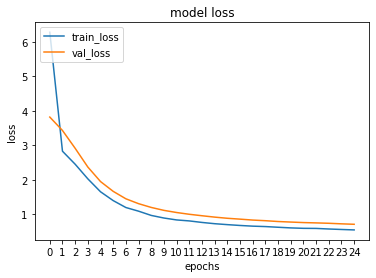

In [19]:
plt.plot(train_loss_accum4)
plt.plot(val_loss_accum4)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

### Plot all model val losses

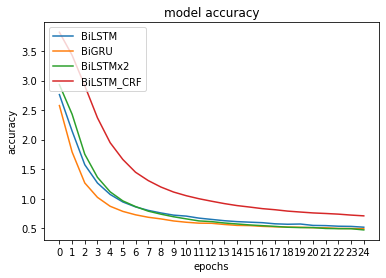

In [20]:
plt.plot(val_loss_accum1)
plt.plot(val_loss_accum2)
plt.plot(val_loss_accum3)
plt.plot(val_loss_accum4)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.xticks(range(N_EPOCHS))
plt.legend(['BiLSTM', 'BiGRU', 'BiLSTMx2', 'BiLSTM_CRF'], loc='upper left')
plt.show()



#### Calculate f1 score for the best model and error analysis

Let's see our model tag some actual sentences.

We define a tag_sentence function that will:
- put the model into evaluation mode
- tokenize the sentence with spaCy if it is not a list
- lowercase the tokens if the Field did
- numericalize the tokens using the vocabulary
- find out which tokens are not in the vocabulary, namely are <unk> tokens
- convert the numericalized tokens into a tensor and add a batch dimension
- feed the tensor into the model
- get the predictions over the sentence
- convert the predictions into readable tags
As well as returning the tokens and tags, it also returns which tokens were <unk> tokens.

In [21]:
def tag_sentence(model, device, sentence, text_field, tag_field):
    model.eval()
    if isinstance(sentence, str):
        nlp = spacy.load('en')
        tokens = [token.text for token in nlp(sentence)]
    else:
        tokens = [token for token in sentence]
    if text_field.lower:
        tokens = [t.lower() for t in tokens]
    numericalized_tokens = [text_field.vocab.stoi[t] for t in tokens]
    unk_idx = text_field.vocab.stoi[text_field.unk_token]
    unks = [t for t, n in zip(tokens, numericalized_tokens) if n == unk_idx]
    token_tensor = torch.LongTensor(numericalized_tokens)
    token_tensor = token_tensor.unsqueeze(-1).to(device)
    predictions = model(token_tensor)
    top_predictions = predictions.argmax(-1)
    predicted_tags = [tag_field.vocab.itos[t.item()] for t in top_predictions]
    return tokens, predicted_tags, unks

In [22]:
example_index = 1

sentence = vars(train_data.examples[example_index])['text']
actual_tags = vars(train_data.examples[example_index])['label']

print(sentence)

['rudolph', 'agnew', ',', '55', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', ',', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate', '.']


In [23]:
tokens, pred_tags, unks = tag_sentence(model_BiLSTMx2, 
                                       device, 
                                       sentence, 
                                       text, 
                                       label)

print(unks)

['agnew', 'conglomerate']


In [24]:
print("Pred. Tag\tActual Tag\tCorrect?\tToken\n")

for token, pred_tag, actual_tag in zip(tokens, pred_tags, actual_tags):
    correct = 'CORRECT' if pred_tag == actual_tag else 'WRONG'
    print(f"{pred_tag}\t\t{actual_tag}\t\t{correct}\t\t{token}")

Pred. Tag	Actual Tag	Correct?	Token

NNP		NNP		✔		rudolph
NNP		NNP		✔		agnew
,		,		✔		,
CD		CD		✔		55
NNS		NNS		✔		years
JJ		JJ		✔		old
CC		CC		✔		and
JJ		JJ		✔		former
NN		NN		✔		chairman
IN		IN		✔		of
NNP		NNP		✔		consolidated
NNP		NNP		✔		gold
NNP		NNP		✔		fields
NNP		NNP		✔		plc
,		,		✔		,
VBD		VBD		✔		was
VBN		VBN		✔		named
DT		DT		✔		a
JJ		JJ		✔		nonexecutive
NN		NN		✔		director
IN		IN		✔		of
DT		DT		✔		this
JJ		JJ		✔		british
NN		JJ		✘		industrial
NN		NN		✔		conglomerate
.		.		✔		.


## F1 score

In [25]:
def remove_punctuation(preds, y):
    preds_no_punct = []
    y_no_punct = []
    for i in range(len(preds)):
        if(bool(re.match('^[a-zA-Z0-9]*$', preds[i])) == True): # if not contains punct chars.
            preds_no_punct.append(preds[i])
            y_no_punct.append(y[i])
    return preds_no_punct, y_no_punct

In [31]:
from sklearn.metrics import f1_score
import re
preds = []
y = []
for i in range(len(test_data.examples)):
    actual_tags = vars(test_data.examples[i])['label']
    sentence = vars(test_data.examples[i])['text']
    _, pred_tags, _ = tag_sentence(model_BiGRU, device, sentence, text, label)
    preds.append(pred_tags)
    y.append(actual_tags)
preds_unflatten = [item for sublist in preds for item in sublist]
y_unflatten = [item for sublist in y for item in sublist]
preds, y = remove_punctuation(preds_unflatten, y_unflatten)
print("F1-score: ", "{:.2f}".format(f1_score(y, preds, average='macro')))

F1-score:  0.73


## Report

In this assignment I implemented 4 different models that perform part-of-speech (PoS) tag for each token in the input text using PyTorch. In particular the 4 models are structured as follows: <br>
1) BiLSTM +  FC <br>
2) BiGRU + FC <br>
3) BiLSTMx2 + FC <br>
4) BiLSTM +  FC + CRF <br>
The models have been trained on the trining set. For each mode, I have chosen the best model considering the validation set seeking at the model with the lowest cross-entropy loss function. At the end, I have chosen, amongst the four models, the one with the highest F1-score calculated on the test set (which is thr BiGRU model) and then I have built a table with the errors that the model does on a specific corpus.
At the beginning the results was not so good because I was doing online learning and I was not applying any regularization technique. Consequently, I decided to modify the training applying a batch size > 1. However, this led into creating a set that requires padding (which will not be considered during the training nor during the calculations of the metrics). Also, I applied dropout to each model to regularize them. These two modifications increased the F1-score of all the models. Moreover, as a requirement, the F1-score should be calculated without considering the punctuations. However, an interesting aspect is that the F1-score, considering the punctuations, turns out to be higher than the one without them. This is exaplainable by the fact that the corpus have a lot of punctuation sign (espetially commas) and therefore the models are able to learn them pretty well.